In [1]:
import re
import nltk
from nltk.tokenize import word_tokenize

# to clean text from special characters
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# to lowercase text
def lowercase_text(text):
    return text.lower() 

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords

# to remove stopwords (stopwords are words that do not add much meaning to a sentence)
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# to vectorize text using tfidf (term frequency inverse document frequency) (a paper also worked on tftidf, but we will work on tfidf)
def vectorize_tfidf(text_data):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)
    return tfidf_matrix

import spacy

In [23]:
import pandas as pd
df = pd.read_csv('seperate.csv') 
df.head()

In [25]:
# to clean text data using the functions we created above
df['cleaned_text'] = df['text'].apply(clean_text) 
df['cleaned_text'] = df['cleaned_text'].apply(lowercase_text)
df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)

https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300/

In [28]:
# For TF-IDF:
tfidf_matrix = vectorize_tfidf(df['cleaned_text'])

In [35]:
import pandas as pd
from gensim.models import KeyedVectors
import nltk
import numpy as np

# drop rows with empty comments
df.dropna(subset=['cleaned_text'], inplace=True)

# Load the GoogleNews Word2Vec model (to generate word embeddings predefined by google)
google_news_model_path = 'GoogleNews-vectors-negative300.bin' 
word2vec_model = KeyedVectors.load_word2vec_format(google_news_model_path, binary=True)
print("Loaded the model")

count = 0
def generate_word_embeddings(tokens):
    global count
    word_embeddings = []
    for word in tokens:
        if word in word2vec_model:
            word_embedding = word2vec_model[word]
            word_embeddings.append(word_embedding)
    count += 1
    if count % 1000 == 0:
        print(count) # to keep track of the progress
    return np.mean(word_embeddings, axis=0) if word_embeddings else np.zeros(word2vec_model.vector_size) 

# Tokenize the lemmatized comments
df['tokens'] = df['cleaned_text'].apply(lambda x: nltk.word_tokenize(x)) 

# Generate word embeddings for each document
df['word-embeddings'] = df['tokens'].apply(generate_word_embeddings)

# Save the processed data with word embeddings
df.to_csv("data_with_word_embeddings.csv", index=False)


Loaded the model
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000

In [36]:
df.head()

,text,Subject,cleaned_text,tokens,word-embeddings
0,Here is our forecast\n\n,NaN,forecast,[forecast],"[-0.12890625, -0.2109375, 0.125, 0.21289062, -..."
1,Traveling to have a business meeting takes the...,Re:,traveling business meeting takes fun trip espe...,"[traveling, business, meeting, takes, fun, tri...","[0.011914266, 0.05225179, 0.0010156758, 0.0672..."
2,test successful. way to go!!!,Re: test,test successful way go,"[test, successful, way, go]","[-0.037597656, 0.059265137, -0.010894775, 0.07..."
3,"Randy,\n\n Can you send me a schedule of the s...",NaN,randy send schedule salary level everyone sche...,"[randy, send, schedule, salary, level, everyon...","[6.2942505e-05, 0.038546085, 0.0038108826, 0.1..."
4,Let's shoot for Tuesday at 11:45.,Re: Hello,lets shoot tuesday,"[lets, shoot, tuesday]","[0.041666668, 0.039245605, 0.1233724, 0.100423..."


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# a random kmeans clustering model (we do not know the best cluster number yet)
kmeans = KMeans(n_clusters=5, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(tfidf_matrix)

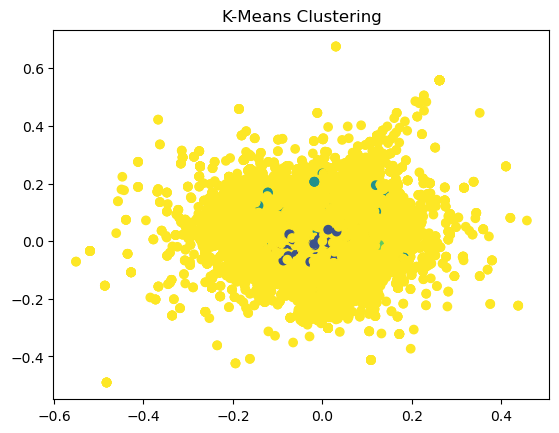

In [39]:
import numpy as np

# to convert the word embeddings into a matrix
embeddings_matrix = np.array(df['word-embeddings'].to_list())

# Scatter plot for K-Means Clustering
plt.scatter(embeddings_matrix[:, 0], embeddings_matrix[:, 1], c=df['kmeans_cluster'], cmap='viridis')
plt.title('K-Means Clustering')
plt.show()


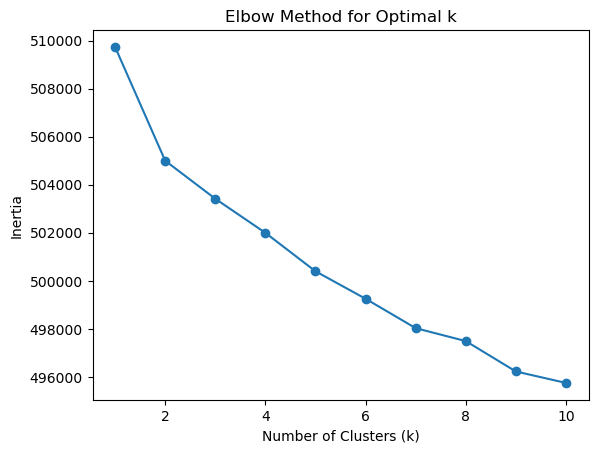

In [40]:
# Elbow Method to find the optimal number of clusters
inertia = []

for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# note that this process took 330 minutes to run on my computer (i7-11800H, 32GB RAM, RTX 3060)

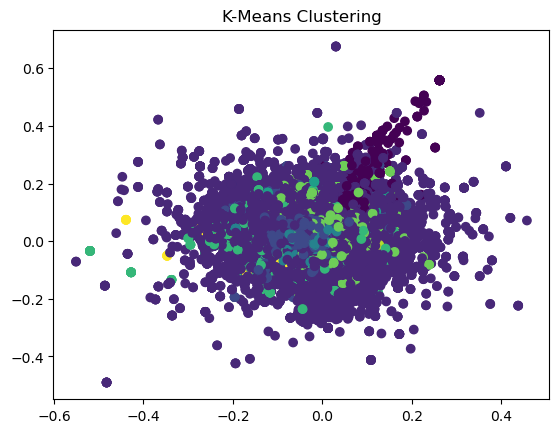

In [41]:
# https://vitalflux.com/k-means-elbow-point-method-sse-inertia-plot-python

# there might be room fore more cluster analysis but the above code ran for 6 and half hours, so we will go with the known information
# and use 10 clusters.

kmeans = KMeans(n_clusters=10, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(tfidf_matrix)

plt.scatter(embeddings_matrix[:, 0], embeddings_matrix[:, 1], c=df['kmeans_cluster'], cmap='viridis')
plt.title('K-Means Clustering')
plt.show()

In [43]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# Convert sparse matrix to dense array
dense_tfidf_matrix = tfidf_matrix.toarray()

# Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=10)
df['agglomerative_cluster'] = agglomerative.fit_predict(dense_tfidf_matrix)

# Dendrogram for hierarchical clustering
dendrogram = sch.dendrogram(sch.linkage(dense_tfidf_matrix, method='ward'))
plt.title('Dendrogram')
plt.show()

# Visualize the hierarchical clustering
plt.scatter(embeddings_matrix[:, 0], embeddings_matrix[:, 1], c=df['agglomerative_cluster'], cmap='viridis')
plt.title('Hierarchical Clustering')
plt.show()


MemoryError: Unable to allocate 2.61 TiB for an array with shape (517401, 693980) and data type float64

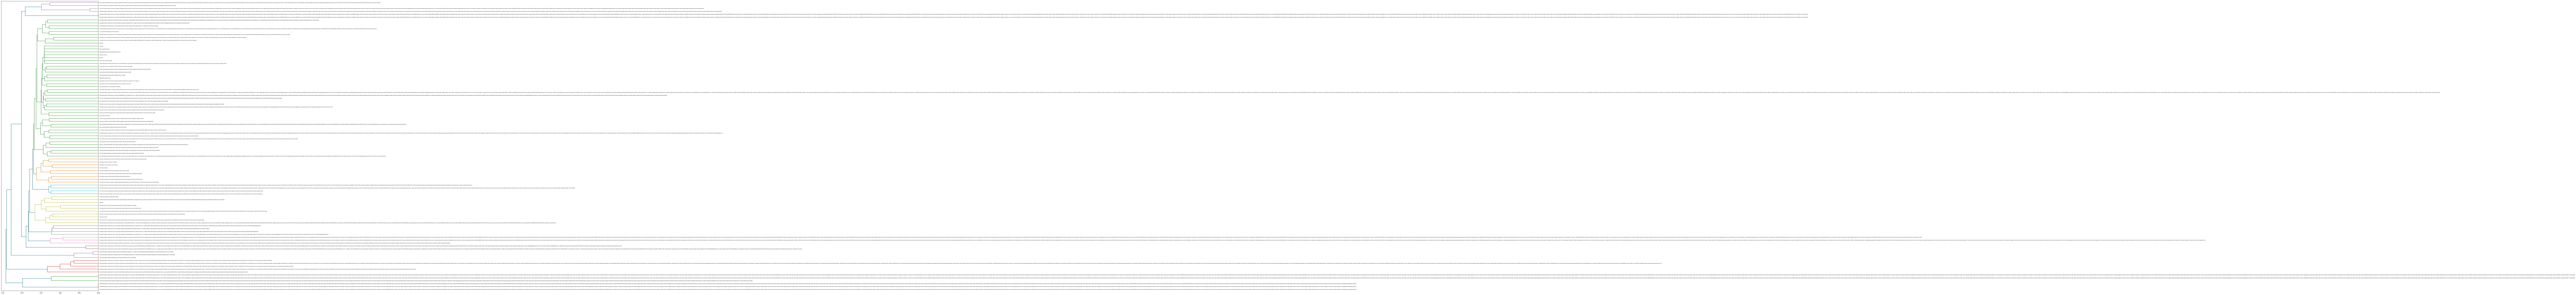

In [57]:
nrows = 100 # to get rid of the memory error
df2 = pd.read_csv("seperate.csv", nrows=nrows)

df2['cleaned_text'] = df2['text'].apply(clean_text)
df2['cleaned_text'] = df2['cleaned_text'].apply(lowercase_text)
df2['cleaned_text'] = df2['cleaned_text'].apply(remove_stopwords)

# Vectorize your text data using TF-IDF
vectorizer2 = TfidfVectorizer()
tfidf_matrix2 = vectorizer2.fit_transform(df2['cleaned_text'])

# K-Means Clustering
kmeans2 = KMeans(n_clusters=10, random_state=42)
df2['kmeans_cluster'] = kmeans2.fit_predict(tfidf_matrix2)

# Convert sparse matrix to dense array
dense_tfidf_matrix2 = tfidf_matrix2.toarray()

# Hierarchical Clustering
agglomerative = AgglomerativeClustering(n_clusters=10, affinity='cosine', linkage='complete')
df2['agglomerative_cluster'] = agglomerative.fit_predict(dense_tfidf_matrix2)

# Dendrogram for hierarchical clustering with word labels
plt.figure(figsize=(10, 30))
dendrogram = sch.dendrogram(sch.linkage(dense_tfidf_matrix2, method='ward'), orientation='left', labels=df2['cleaned_text'].tolist())
plt.show()

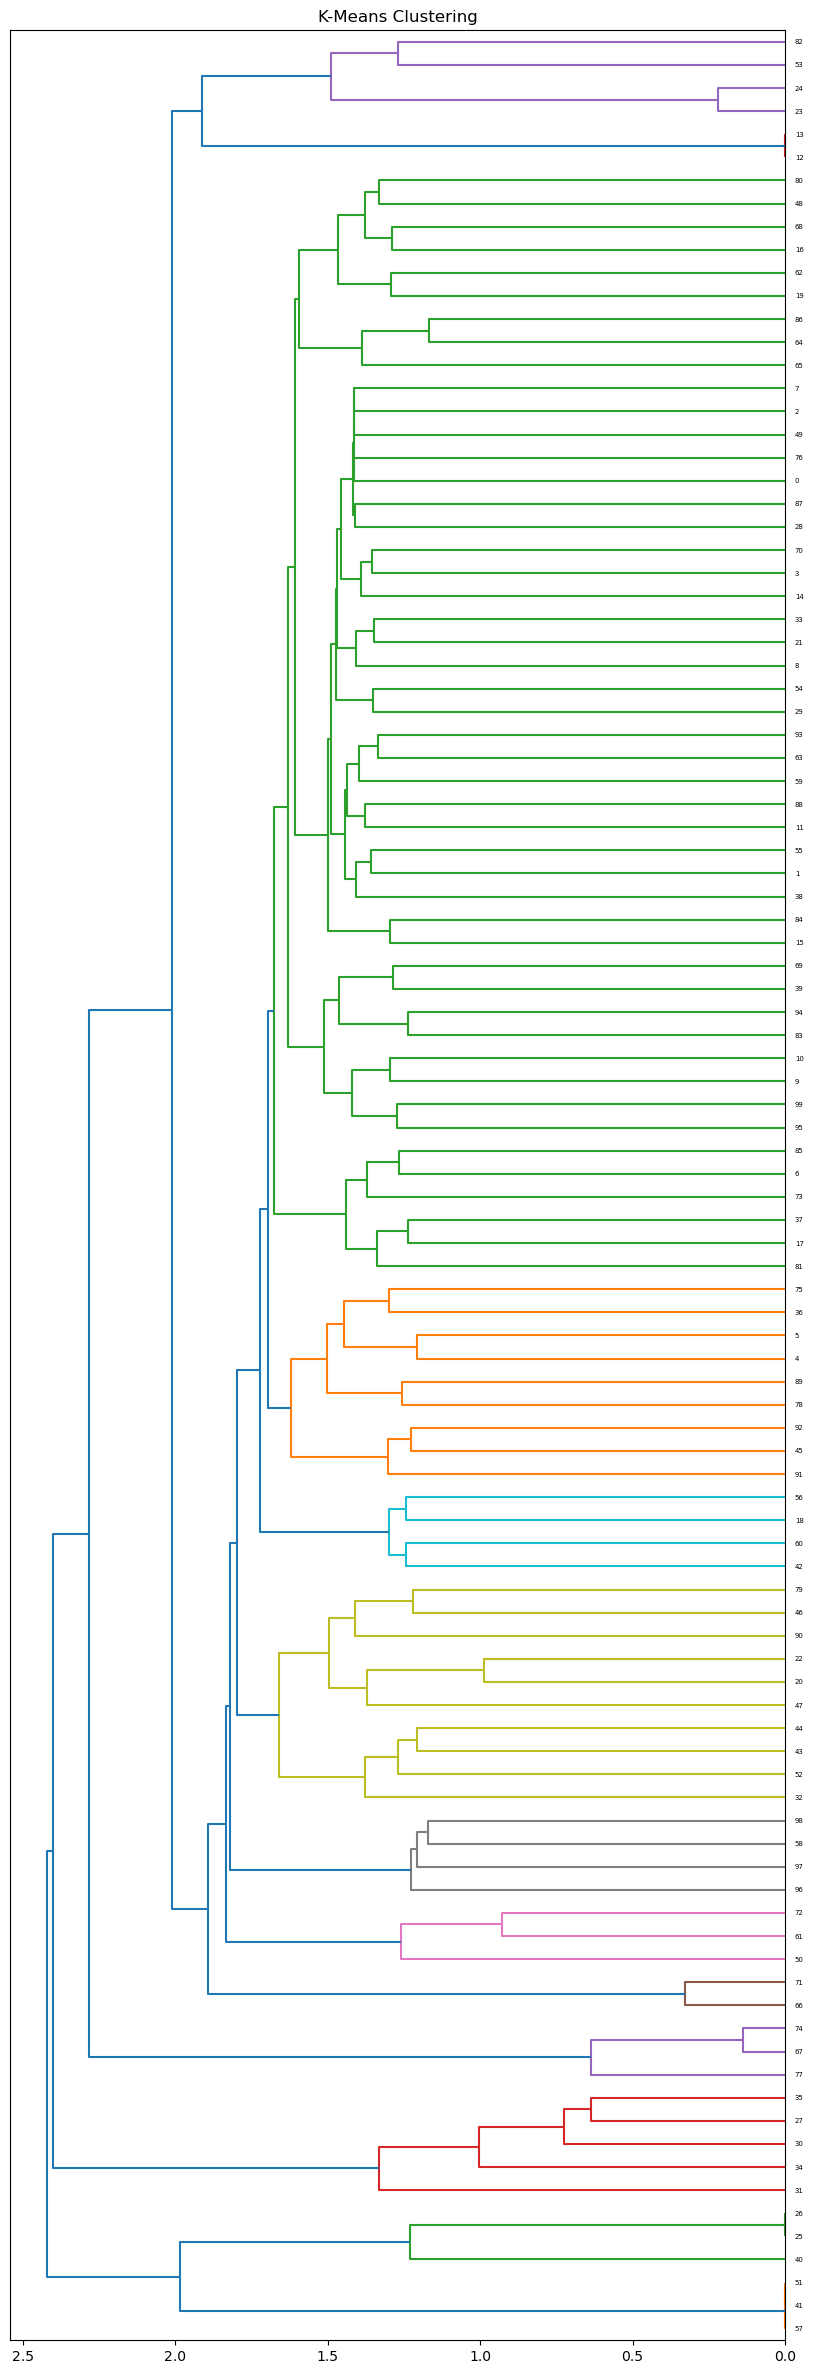

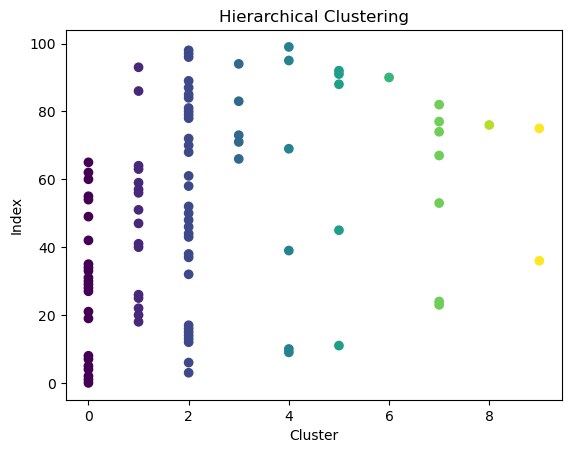

In [67]:
# above is the text version but we will represent it in terms of number for the simplicity of the understanding the correlation

# Dendrogram for hierarchical clustering
plt.figure(figsize=(10, 30))  # Adjust the size as needed
dendrogram = sch.dendrogram(sch.linkage(dense_tfidf_matrix2, method='ward'), orientation='left')
plt.title('K-Means Clustering')
plt.show()

# Plot Hierarchical Clustering
plt.scatter(df2['agglomerative_cluster'], range(len(df2)), c=df2['agglomerative_cluster'], cmap='viridis')
plt.title('Hierarchical Clustering')
plt.xlabel('Cluster')
plt.ylabel('Index')
plt.show()

In the tree, each cluster has a different color and when the blue tree edge goes to the end (to the node itself) there is a short red line which indicates that it is an outlier. The below scatter plot represents the numerical value (the index of the csv line of the text) of the text and its cluster (x is cluster and y is index)